In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
# ---- 한글 폰트 설정 ----
# (Windows) 보통 'Malgun Gothic'
plt.rc('font', family='Malgun Gothic')  
# (Mac) 보통 'AppleGothic'
# plt.rc('font', family='AppleGothic')
# (Linux, Colab) 나눔글꼴 경로 지정 필요할 수 있음
# plt.rc('font', family='NanumGothic')

plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

In [78]:

df = pd.read_csv("../data/processed/train_cluster.csv", encoding="utf-8")


In [79]:
df.shape

(40856, 112)

In [80]:
print(list(df.columns))

['num', 'biz_type', 'market', 'is_franchise', 'open', 'is_cold_start', 'is_market_missing', 'biz_type_adj', 'market_adj', 'base_ym', 'target_ym', 'y', 'oper_month_grp_mean', 'sales_grp_mean', 'txn_cnt_grp_mean', 'cust_cnt_grp_mean', 'avg_pay_grp_mean', 'cancel_rate_grp_mean', 'delivery_sales_ratio_mean', 'rel_sales_ratio_mean', 'rel_txn_ratio_mean', 'sales_rank_industry_mean', 'sales_rank_market_mean', 'share_sales_industry_mean', 'share_sales_market_mean', 'male_20below_ratio_mean', 'male_30_ratio_mean', 'male_40_ratio_mean', 'male_50_ratio_mean', 'male_60plus_ratio_mean', 'female_20below_ratio_mean', 'female_30_ratio_mean', 'female_40_ratio_mean', 'female_50_ratio_mean', 'female_60plus_ratio_mean', 'revisit_ratio_mean', 'new_ratio_mean', 'resident_ratio_mean', 'worker_ratio_mean', 'floating_ratio_mean', 'sales_estimate_mean', 'is_customer_missing_mean', 'is_behavior_missing_mean', 'is_type_missing_mean', 'is_delivery_missing_mean', 'oper_month_grp_std', 'sales_grp_std', 'txn_cnt_grp_

# XGBOOST

In [81]:
# ============================
# XGBoost 전체 학습 파이프라인
#  - 입력: df (슬라이딩 윈도우 요약 포함)
#  - 타깃: y (해당 target_ym 매출)
#  - 검증: 최근 K개월 hold-out
# ============================
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --------------------------------
# 0) df 준비 (이미 로드되어 있다고 가정)
#    df: ['num','target_ym','y', ... 슬라이딩 요약 피처들 ...]
# --------------------------------
# 날짜형 변환 & 정렬
if not np.issubdtype(pd.Series(df['target_ym']).dtype, np.datetime64):
    df['target_ym'] = pd.to_datetime(df['target_ym'], errors='coerce')
df = df.sort_values(['target_ym', 'num']).reset_index(drop=True)

# --------------------------------
# 1) Feature 선택 규칙
#    - 제거: 식별/누수/날짜/원본문자열
#    - 사용: *_mean, *_std, *_last, 정수/실수형 고정변수, 클러스터 등
# --------------------------------
drop_cols = {
    'y','num', 'base_ym', 'target_ym',  # 타깃/식별/날짜
    'biz_type', 'market'  #,'sales_estimate_mean','sales_estimate_last' ,
    #'rel_sales_ratio_mean','rel_sales_ratio_last',              # 원본문자열(정제본이 있으면 그쪽만 사용)
    #'sales_grp_mean','sales_grp_last',
    #'sales_rank_industry_last','sales_rank_industry_mean'
}

# 우선 전체 컬럼에서 drop 제외
candidate_cols = [c for c in df.columns if c not in drop_cols]

# 객체형(문자열) 중에서 사용하고 싶은 범주형만 선택 (원-핫 인코딩)
cat_keep = []
for c in candidate_cols:
    if df[c].dtype == 'object':
        # 정제본이 있다면 사용: 'market_adj','biz_type_adj'
        if c in ['market_adj', 'biz_type_adj']:
            cat_keep.append(c) 

# 숫자형 및 불리언/클러스터 포함
num_keep = []
for c in candidate_cols:
    if c in cat_keep:
        continue
    if np.issubdtype(df[c].dtype, np.number):
        num_keep.append(c)


# 최종 X 컬럼 (원-핫 인코딩 적용 전)
X_cols = num_keep #+ cat_keep
print(X_cols)

['is_franchise', 'is_cold_start', 'is_market_missing', 'oper_month_grp_mean', 'sales_grp_mean', 'txn_cnt_grp_mean', 'cust_cnt_grp_mean', 'avg_pay_grp_mean', 'cancel_rate_grp_mean', 'delivery_sales_ratio_mean', 'rel_sales_ratio_mean', 'rel_txn_ratio_mean', 'sales_rank_industry_mean', 'sales_rank_market_mean', 'share_sales_industry_mean', 'share_sales_market_mean', 'male_20below_ratio_mean', 'male_30_ratio_mean', 'male_40_ratio_mean', 'male_50_ratio_mean', 'male_60plus_ratio_mean', 'female_20below_ratio_mean', 'female_30_ratio_mean', 'female_40_ratio_mean', 'female_50_ratio_mean', 'female_60plus_ratio_mean', 'revisit_ratio_mean', 'new_ratio_mean', 'resident_ratio_mean', 'worker_ratio_mean', 'floating_ratio_mean', 'sales_estimate_mean', 'is_customer_missing_mean', 'is_behavior_missing_mean', 'is_type_missing_mean', 'is_delivery_missing_mean', 'oper_month_grp_std', 'sales_grp_std', 'txn_cnt_grp_std', 'cust_cnt_grp_std', 'avg_pay_grp_std', 'cancel_rate_grp_std', 'delivery_sales_ratio_std', 

In [82]:


# --------------------------------
# 2) 전처리: 결측치
#    - *_missing_* 지표는 결측을 0으로
#    - 나머지는 중앙값 대치
# --------------------------------
X_raw = df[X_cols].copy()

# 범주형 원-핫
#cat_cols = [c for c in cat_keep if c in X_raw.columns]
#X = pd.get_dummies(X_raw, columns=cat_cols, drop_first=True)
X = X_raw

# 타깃
y = df['y'].astype(float)

# --------------------------------
# 3) 시계열 홀드아웃: 최근 K개월을 테스트로
# --------------------------------
K = 3  # 최근 3개월 hold-out
last_months = sorted(df['target_ym'].dropna().unique())[-K:]

is_test = df['target_ym'].isin(last_months)
X_train, X_test = X.loc[~is_test], X.loc[is_test]
y_train, y_test = y.loc[~is_test], y.loc[is_test]

print(f"학습 기간: {X_train.shape}, 검증 기간(최근 {K}개월): {X_test.shape}")

# --------------------------------
# 4) XGBoost 학습
# --------------------------------
model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)



학습 기간: (29992, 103), 검증 기간(최근 3개월): (10864, 103)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=-1, num_parallel_tree=None, ...)

In [89]:
import pandas as pd
import numpy as np

# df: 전체 feature 데이터프레임 (y 제외)
corr_matrix = X_raw.corr().abs()

# 상삼각행렬(중복 제거)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 0.8 이상인 쌍 추출
high_corr_pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'corr'})
    .query('corr >= 0.9')
    .sort_values(by='corr', ascending=False)
)

print(f"🔍 상관계수 0.8 이상 변수쌍 개수: {len(high_corr_pairs)}")
display(high_corr_pairs)


🔍 상관계수 0.8 이상 변수쌍 개수: 37


,var1,var2,corr
1135,sales_rank_market_mean,sales_rank_market_last,0.997050
250,oper_month_grp_mean,oper_month_grp_last,0.995474
1051,sales_rank_industry_mean,sales_rank_industry_last,0.993059
1771,female_20below_ratio_mean,female_20below_ratio_last,0.992925
1381,male_20below_ratio_mean,male_20below_ratio_last,0.991512
2605,is_delivery_missing_mean,is_delivery_missing_last,0.989723
793,delivery_sales_ratio_mean,delivery_sales_ratio_last,0.986000
2065,female_60plus_ratio_mean,female_60plus_ratio_last,0.983264
1618,male_50_ratio_mean,male_50_ratio_last,0.982989
1695,male_60plus_ratio_mean,male_60plus_ratio_last,0.982975


📊 MAE: 8,440
📈 R² : 0.876

[Top-20 Feature Importance]
sales_estimate_mean          0.517807
sales_estimate_last          0.104937
rel_sales_ratio_mean         0.026841
avg_pay_grp_std              0.010990
sales_rank_industry_last     0.009980
avg_pay_grp_last             0.008994
female_60plus_ratio_mean     0.008114
share_sales_industry_mean    0.006267
cust_cnt_grp_std             0.005881
new_ratio_mean               0.005598
sales_rank_industry_mean     0.005328
share_sales_industry_last    0.005281
rel_txn_ratio_last           0.005228
oper_month_grp_last          0.005204
female_60plus_ratio_last     0.005159
male_30_ratio_mean           0.004825
txn_cnt_grp_std              0.004797
male_50_ratio_mean           0.004780
resident_ratio_last          0.004678
share_sales_industry_std     0.004651
dtype: float32


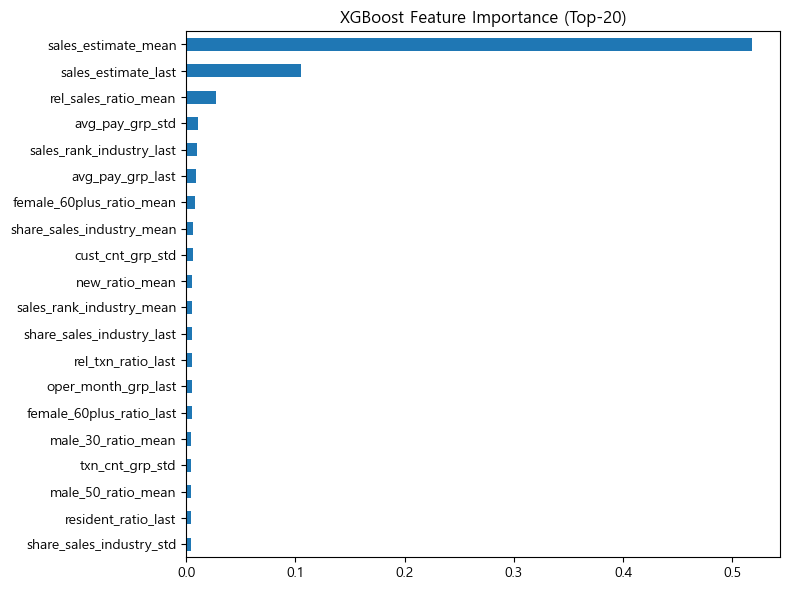


[최근 K개월 예측 샘플]
              num  target_ym           y        y_pred       abs_err
29992  000F03E44A 2024-03-01    788.9310    282.766998    506.164002
33568  000F03E44A 2024-04-01   1911.6405   4541.369141   2629.728641
37190  000F03E44A 2024-05-01   4308.7770   5957.647461   1648.870461
29993  002816BA73 2024-03-01  19796.6244  30332.781250  10536.156850
33569  002816BA73 2024-04-01  17152.9758  32094.781250  14941.805450
37191  002816BA73 2024-05-01  15206.1028  25266.529297  10060.426497
29994  003473B465 2024-03-01      0.0000   1340.308472   1340.308472
33570  003473B465 2024-04-01      0.0000   1179.581299   1179.581299
37192  003473B465 2024-05-01      0.0000    636.987366    636.987366
29995  003AC99735 2024-03-01  51033.2300  48843.007812   2190.222188


In [51]:
# --------------------------------
# 5) 평가
# --------------------------------
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
r2  = r2_score(y_test, pred)

print(f"📊 MAE: {mae:,.0f}")
print(f"📈 R² : {r2:.3f}")

# --------------------------------
# 6) 중요도 Top-20 확인
# --------------------------------
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
topk = importances.head(20)
print("\n[Top-20 Feature Importance]")
print(topk)

plt.figure(figsize=(8,6))
topk.sort_values().plot(kind='barh')
plt.title("XGBoost Feature Importance (Top-20)")
plt.tight_layout()
plt.show()

# --------------------------------
# 7) 예측 결과 프레임 (num, target_ym와 붙여 보기)
# --------------------------------
out = df.loc[is_test, ['num','target_ym','y']].copy()
out['y_pred'] = pred
out['abs_err'] = (out['y'] - out['y_pred']).abs()
out = out.sort_values(['num','target_ym'])
print("\n[최근 K개월 예측 샘플]")
print(out.head(10))

In [ ]:
# ============================
# 클러스터별 XGBoost 학습/평가 (최근 K개월 hold-out)
# - df: ['num','target_ym','y', ... , 'moe_cluster' or 'gmm_cluster']
# - 위에서 만든 X_cols를 그대로 활용
# ============================

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# 1) 클러스터 컬럼 선택
if 'moe_cluster' in df.columns:
    cluster_col = 'moe_cluster'
elif 'gmm_cluster' in df.columns:
    cluster_col = 'gmm_cluster'
else:
    raise ValueError("클러스터 컬럼(moe_cluster/gmm_cluster)이 df에 없습니다.")

# 혹시 X_cols에 클러스터 컬럼이 들어가 있었다면 제거 (세그먼트 기준으로 나눠 학습하므로)
X_cols_cluster = [c for c in X_cols if c != cluster_col]

# 2) 최근 K개월 hold-out 마스크 (위에서 df 정렬/변환은 끝난 상태)
K = 3
last_months = sorted(df['target_ym'].dropna().unique())[-K:]
is_test = df['target_ym'].isin(last_months)

# 3) 클러스터 루프
results = []
feature_importances = {}  # {cluster: pd.Series(top-20)}

clusters = sorted(df[cluster_col].dropna().unique())
min_train, min_test = 50, 20  # 표본 부족 방지

for cl in clusters:
    tr_idx = (~is_test) & (df[cluster_col] == cl)
    te_idx = ( is_test) & (df[cluster_col] == cl)

    tr = df.loc[tr_idx, X_cols_cluster + ['y', 'target_ym']].copy()
    te = df.loc[te_idx, X_cols_cluster + ['y', 'target_ym']].copy()

    if len(tr) < min_train or len(te) < min_test:
        print(f"[skip] cluster={cl}: train {len(tr)} / test {len(te)} (표본 부족)")
        continue

    # 결측 간단 보정(중앙값)
    X_tr = tr[X_cols_cluster].copy()
    X_te = te[X_cols_cluster].copy()
    for c in X_tr.columns:
        if X_tr[c].isna().any():
            med = X_tr[c].median()
            X_tr[c] = X_tr[c].fillna(med)
            X_te[c] = X_te[c].fillna(med)  # train 통계로 채움

    y_tr = tr['y'].astype(float)
    y_te = te['y'].astype(float)

    # 모델
    model = XGBRegressor(
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        tree_method="hist",
        n_jobs=-1
    )
    model.fit(X_tr, y_tr)

    # 예측/성능
    pred = model.predict(X_te)
    mae = mean_absolute_error(y_te, pred)
    r2  = r2_score(y_te, pred)

    # 월별 MAE(검증 구간 내부)
    te_month = te[['target_ym']].copy()
    te_month['y'], te_month['pred'] = y_te.values, pred
    month_mae = (te_month
                 .groupby(te_month['target_ym'].dt.to_period('M'))
                 .apply(lambda g: mean_absolute_error(g['y'], g['pred']))
                 .astype(float))

    # 중요도(gain) 상위 20
    booster = model.get_booster()
    gain = booster.get_score(importance_type="gain")  # {'f0': gain, ...}
    fmap = {f"f{i}": n for i, n in enumerate(X_tr.columns)}
    imp = (pd.Series({fmap.get(k, k): v for k, v in gain.items()})
             .sort_values(ascending=False)
             .head(20))
    feature_importances[cl] = imp

    print(f"[cluster {cl}] n_tr={len(tr):,}, n_te={len(te):,} | MAE={mae:,.0f}, R²={r2:.3f}")
    print(imp)

    results.append({
        "cluster": cl,
        "n_train": len(tr),
        "n_test": len(te),
        "MAE": mae,
        "R2": r2
    })

# 4) 요약 및 가중 평균
summary = pd.DataFrame(results).sort_values("cluster")
if not summary.empty:
    weights = summary['n_test'] / summary['n_test'].sum()
    w_mae = (summary['MAE'] * weights).sum()
    w_r2  = (summary['R2']  * weights).sum()  # 참고용

    print("\n=== 클러스터별 요약 ===")
    print(summary)
    print(f"\n가중 평균 MAE: {w_mae:,.0f}")
    print(f"가중 평균 R² : {w_r2:.3f}")
else:
    print("클러스터별 결과가 없습니다(표본 부족으로 모두 스킵).")


[cluster 0] n_tr=1,701, n_te=633 | MAE=3,901, R²=-0.267
sales_rank_industry_last    7.899203e+09
sales_estimate_mean         3.430263e+09
rel_sales_ratio_mean        1.573570e+09
rel_sales_ratio_last        1.407372e+09
sales_rank_industry_mean    1.253090e+09
sales_grp_std               1.083474e+09
cust_cnt_grp_mean           5.561061e+08
sales_grp_last              4.777628e+08
male_50_ratio_last          3.807021e+08
cust_cnt_grp_std            3.193439e+08
male_50_ratio_mean          3.024552e+08
new_ratio_last              3.016056e+08
revisit_ratio_std           2.227075e+08
sales_estimate_last         2.050082e+08
cust_cnt_grp_last           1.707722e+08
rel_txn_ratio_mean          1.692136e+08
rel_txn_ratio_std           1.625845e+08
cancel_rate_grp_mean        1.333465e+08
share_sales_market_last     1.320850e+08
female_40_ratio_mean        1.302090e+08
dtype: float64
[cluster 1] n_tr=758, n_te=301 | MAE=5,043, R²=0.778
sales_estimate_mean          5.106714e+09
sales_estimate

## 0클러스터만 다시 분석

In [ ]:
# =========================================
# Cluster 0 전용: 비(非)ML 베이스라인 예측 파이프라인
# - 방법: 전월값(lag1), 3개월 이동평균(MA3), 계절 나이브(전년동월), 간단 앙상블
# - 출력: 각 방법의 MAE / MAPE / R² (테스트: 최근 K개월)
# 필요 컬럼: ['num','target_ym','y', 'moe_cluster' or 'gmm_cluster']
# =========================================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

# 0) 파라미터
K = 3  # 최근 K개월을 테스트로
cluster_col = 'moe_cluster' if 'moe_cluster' in df.columns else 'gmm_cluster'
assert cluster_col in df.columns, "클러스터 컬럼이 없습니다."

# 1) 날짜 정렬/형 변환
if not np.issubdtype(pd.Series(df['target_ym']).dtype, np.datetime64):
    df['target_ym'] = pd.to_datetime(df['target_ym'], errors='coerce')
df = df.sort_values(['num','target_ym']).reset_index(drop=True)

# 2) Cluster 0만 선택
df0 = df[df[cluster_col] == 0].copy()
assert not df0.empty, "Cluster 0 데이터가 비어 있습니다."
last_months = sorted(df0['target_ym'].dropna().unique())[-K:]
is_test0 = df0['target_ym'].isin(last_months)

# 3) 베이스라인 타임 시리즈 파생
# 전월값(lag1)
df0['y_lag1'] = df0.groupby('num')['y'].shift(1)
# 3개월 이동평균(MA3) - 바로 직전 3개 관측의 평균
df0['y_ma3']  = df0.groupby('num')['y'].shift(1).rolling(3).mean().reset_index(level=0, drop=True)
# 계절 나이브(전년 동월): 월단위 가정 → 12개월 전 값
df0['y_seasonal'] = df0.groupby('num')['y'].shift(12)

# 4) 평가 지표 함수
def safe_mape(y_true, y_pred, eps=1e-6):
    # 0 나눗셈 방지용 eps
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def eval_baseline(df_subset, pred_col):
    mask = (~df_subset[pred_col].isna()) & (~df_subset['y'].isna())
    if mask.sum() == 0:
        return np.nan, np.nan, np.nan
    y_true = df_subset.loc[mask, 'y'].values
    y_pred = df_subset.loc[mask, pred_col].values
    mae  = mean_absolute_error(y_true, y_pred)
    mape = safe_mape(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return mae, mape, r2

# 5) 테스트 구간에서 각 베이스라인 성능
te = df0.loc[is_test0].copy()

results = {}
for name, col in [('lag1','y_lag1'), ('ma3','y_ma3'), ('seasonal','y_seasonal')]:
    mae, mape, r2 = eval_baseline(te, col)
    results[name] = {'MAE': mae, 'MAPE(%)': mape, 'R2': r2}

# 6) 간단 앙상블(가중 평균): lag1과 ma3를 섞어서 MAE가 최소가 되는 w 탐색
#    pred = w*lag1 + (1-w)*ma3  (w∈[0,1])
def best_weight_lag_ma3(te_df):
    df_ens = te_df[['y','y_lag1','y_ma3']].dropna()
    if df_ens.empty:
        return np.nan, None
    ys  = df_ens['y'].values
    l1  = df_ens['y_lag1'].values
    ma3 = df_ens['y_ma3'].values

    best_w, best_mae = 0.5, np.inf
    for w in np.linspace(0, 1, 21):  # 0.00 ~ 1.00 step 0.05
        pred = w*l1 + (1-w)*ma3
        mae = mean_absolute_error(ys, pred)
        if mae < best_mae:
            best_mae, best_w = mae, w
    return best_w, best_mae

w_opt, _ = best_weight_lag_ma3(te)
if not np.isnan(w_opt):
    te_ens = te[['y','y_lag1','y_ma3']].dropna().copy()
    te_ens['y_pred_ens'] = w_opt*te_ens['y_lag1'] + (1-w_opt)*te_ens['y_ma3']
    mae, mape, r2 = mean_absolute_error(te_ens['y'], te_ens['y_pred_ens']), \
                    safe_mape(te_ens['y'], te_ens['y_pred_ens']), \
                    r2_score(te_ens['y'], te_ens['y_pred_ens'])
    results[f'ensemble(lag1,ma3,w={w_opt:.2f})'] = {'MAE': mae, 'MAPE(%)': mape, 'R2': r2}

# 7) 요약 출력
print(f"[Cluster 0] Test months: {pd.Series(last_months).dt.to_period('M').astype(str).tolist()}")
print("\n=== Cluster 0 | 비ML 베이스라인 성능(최근 K개월) ===")
res_df = pd.DataFrame(results).T.sort_values('MAE')
print(res_df)




[Cluster 0] Test months: ['2024-03', '2024-04', '2024-05']

=== Cluster 0 | 비(非)ML 베이스라인 성능(최근 K개월) ===
                                   MAE       MAPE(%)        R2
ensemble(lag1,ma3,w=0.85)  3062.235635  1.787530e+11 -0.237106
lag1                       3941.998804  1.005401e+11 -0.756735
ma3                        4688.777822  1.225284e+11 -0.890720
seasonal                           NaN           NaN       NaN


In [61]:
# =====================================
# Cluster 0: naive baseline
# y_hat_t = 지난달 sales_estimate_mean
# =====================================
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

cluster_col = 'moe_cluster' if 'moe_cluster' in df.columns else 'gmm_cluster'
df0 = df[df[cluster_col] == 0].copy()

# 정렬
df0 = df0.sort_values(['num','target_ym']).reset_index(drop=True)

# 지난달 sales_estimate_mean (점포별 lag1)
df0['lag1_sales_est'] = df0.groupby('num')['sales_estimate_mean'].shift(1)

# 예측 vs 실제
mask = ~df0['lag1_sales_est'].isna()
y_true = df0.loc[mask, 'y'].astype(float)
y_pred = df0.loc[mask, 'lag1_sales_est'].astype(float)

# 성능 지표
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)

print(f"[Cluster 0 | naive sales_estimate_mean(lag1)] MAE={mae:,.0f}, R²={r2:.3f}")


[Cluster 0 | naive sales_estimate_mean(lag1)] MAE=4,117, R²=0.755
